Trying to build a random forest classifer to segment genes into three groups:
- ssRNAP
- multi-subunit RPOL
- other

We'll use two sets of ~30 representative genes for the first two groups, and the E coli proteome minus polymerases for the "other" groups

### Batch command used to generate embeddings:

```
python scripts/extract.py esm2_t33_650M_UR50D data/<sequences>.fasta output/<sequences>_reprs --repr_layers 0 32 33 --include mean per_tok
```


In [51]:
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import esm

In [71]:
import scipy
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.cluster import DBSCAN

### Load data:


In [53]:
ss_FASTA_PATH = "../data/rnap-phage-interpro-annotated-v1.fasta.txt"
b_FASTA_PATH = "../data/uniprotkb_accession_A0QS66_OR_accession_2024_03_03-subunit-beta.fasta"
ss_EMB_PATH = "../output/rnap_phage_interpro_v1_reprs"
b_EMB_PATH = "../output/uniprot_subunit_beta_03_03_reprs"
other_EMB_PATH = "../output/e_coli_NOT_ec_2_7_7_6_reprs"
other_FASTA_PATH = "../data/uniprotkb_e_coli_NOT_ec_2_7_7_6_AND_rev_2024_03_06.fasta"
EMB_LAYER = 33

In [54]:
ss_embs, ss_headers = ([], [])
for header, _seq in esm.data.read_fasta(ss_FASTA_PATH):
    fn = f'{ss_EMB_PATH}/{header}.pt' # path to ESM output, per sequence
    emb = torch.load(fn)
    reprs = emb['mean_representations'][EMB_LAYER]
    ss_embs.append(reprs)
    ss_headers.append(header)
Xs_ss = torch.stack(ss_embs, dim=0).numpy()

b_embs, b_headers = ([], [])
for header, _seq in esm.data.read_fasta(b_FASTA_PATH):
    fn = f'{b_EMB_PATH}/{header}.pt' # path to ESM output, per sequence
    emb = torch.load(fn)
    reprs = emb['mean_representations'][EMB_LAYER]
    b_embs.append(reprs)
    b_headers.append(header)
Xs_b = torch.stack(b_embs, dim=0).numpy()

other_embs, other_headers = ([], [])
for header, _seq in esm.data.read_fasta(other_FASTA_PATH):
    fn = f'{other_EMB_PATH}/{header}.pt' # path to ESM output, per sequence
    emb = torch.load(fn)
    reprs = emb['mean_representations'][EMB_LAYER]
    other_embs.append(reprs)
    other_headers.append(header)
Xs_other = torch.stack(other_embs, dim=0).numpy()

In [55]:
FASTA_PATH = "../data/uniprotkb_2024_02_15.fasta"
EMB_PATH = "../output/uniprot_2024_02_15_reprs"
embs, headers = ([], [])
for header, _seq in esm.data.read_fasta(FASTA_PATH):
    fn = f'{EMB_PATH}/{header}.pt' # path to ESM output, per sequence
    emb = torch.load(fn)
    reprs = emb['mean_representations'][EMB_LAYER].numpy()
    embs.append(reprs)
    headers.append(header)

T7_RNAP_emb = embs[3]

In [56]:
df1 = pd.DataFrame()
distances_ss = cosine_similarity(T7_RNAP_emb.reshape(1, -1), Xs_ss)
df1["ID"] = ss_headers
df1["distance"] = distances_ss.reshape(-1, 1)
df1["distance"] = 1 - df1["distance"]
df1["type"] = "ssRNAP"

df2 = pd.DataFrame()
distances_b = cosine_similarity(T7_RNAP_emb.reshape(1, -1), Xs_b)
df2["ID"] = b_headers
df2["distance"] = distances_b.reshape(-1, 1)
df2["distance"] = 1 - df2["distance"]
df2["type"] = "RNAP subunit beta/beta'"

df3 = pd.DataFrame()
distances_other = cosine_similarity(T7_RNAP_emb.reshape(1, -1), Xs_other)
df3["ID"] = other_headers
df3["distance"] = distances_other.reshape(-1, 1)
df3["distance"] = 1 - df3["distance"]
df3["type"] = "other"

In [57]:
df = pd.concat([df1, df2, df3])

### Visualize embeddings for model training

Text(0.5, 0, '')

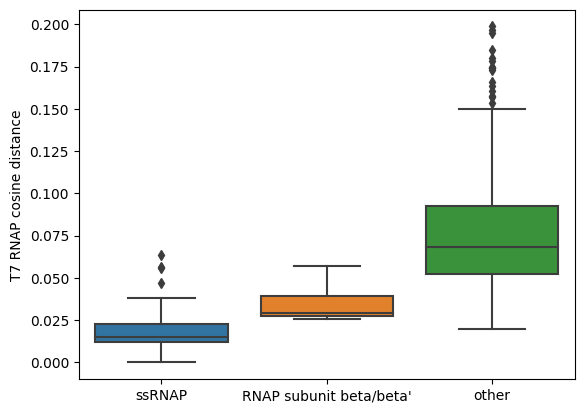

In [58]:
sns.boxplot(data=df[df.distance < 0.2], x="type", y="distance")
plt.ylabel("T7 RNAP cosine distance")
plt.xlabel("")

The three groups separate cleanly in embedding space. Here, we show the cosine distance between T7 ssRNAP and sequences in each group. As expected, other ssRNAPs are closer, followed by the multi-subunit RPOL core and the E. coli proteome genes. 

In [59]:
embs_all = np.concatenate((Xs_ss, Xs_b, Xs_other), axis=0)
embs_all.shape

(609, 1280)

In [242]:
num_pca_components = 200
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(embs_all)

Text(0, 0.5, 'PC2')

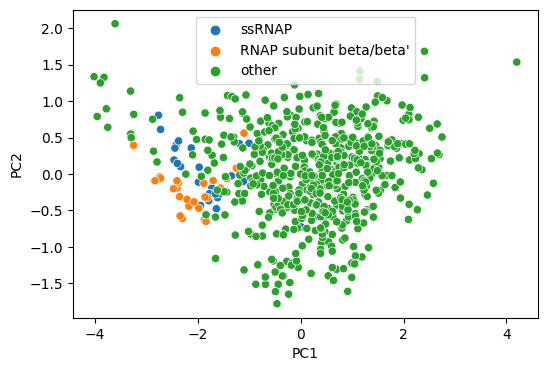

In [204]:
rcParams['figure.figsize'] = [6, 4]
g = sns.scatterplot(x=Xs_train_pca[:,0], y=Xs_train_pca[:,1], hue=list(df["type"]))
plt.xlabel("PC1")
plt.ylabel("PC2")

In [252]:
#sns.scatterplot(x = [x for x in range(1, 61)], y = pca.explained_variance_ratio_)

### Train/test classifier

Next, we'll train a random forest model to classify the three gene groupings. Since the total size of the dataset is small (~600 sequences) we don't want to use all 1280 embedding dimensions, so we will run a PCA to do dimensionality reduction

In [254]:
num_pcs = [x for x in range(1, 200)] # try 1-200 PCs
train_size = 0.8

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
scores = []
for n in num_pcs:
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs_train_pca[:,:n], list(df["type"]), train_size=train_size, random_state=42)
    clf.fit(Xs_train, ys_train)
    scores.append(clf.score(Xs_test, ys_test))

Text(0, 0.5, 'Test-set prediction accuracy')

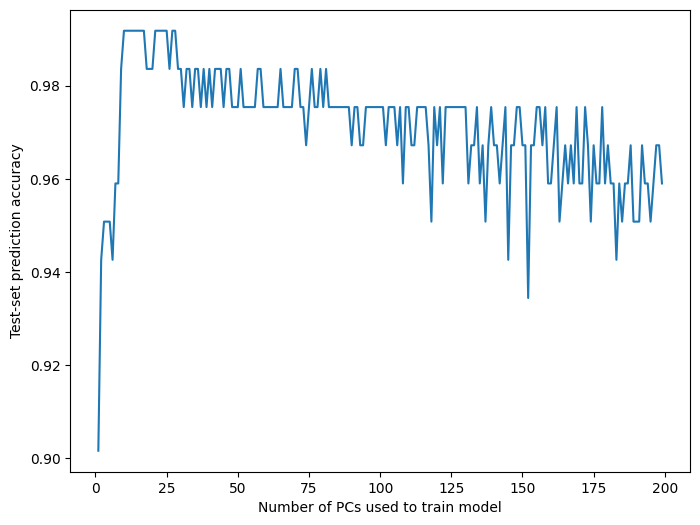

In [258]:
sns.lineplot(x = num_pcs, y = scores)
plt.xlabel("Number of PCs used to train model")
plt.ylabel("Test-set prediction accuracy")

Using ~20 PCs from the transformed training data seems to yield the best performance

### Validate on metagenomic phage data
Finally, we'll run the classifier over a set of 100K genes from unidentified phages (from a human gut metagenomic study). These genes were pre-annotated using BLAST, so we can use that as a baseline to compare the model against. 

In [186]:
# load data
df_master = pd.read_csv('../output/phage_metagenomic_embeddings.csv', header=None)
df_master = df_master.rename(columns={0: "ID", 1: "desc"})
embeddings = df_master.iloc[:, 2:].to_numpy()
embeddings.shape

(117312, 1280)

In [259]:
Xs_validate_pca = pca.transform(embeddings)

In [266]:
model = RandomForestClassifier()
pcs = 25
# re-train model on all training data, using best PC number
model.fit(Xs_train_pca[:,:pcs], list(df["type"]))

RandomForestClassifier()

In [ ]:
pred = model.predict(Xs_validate_pca[:,:pcs])
df_master["predictions"] = list(pred)
df_master["prob"] = list(model.predict_proba(Xs_validate_pca[:,:pcs]))
df_master["beta_prob"] = [probas[0] for probas in df_master["prob"]]
df_master["other_prob"] = [probas[1] for probas in df_master["prob"]]
df_master["ssRNAP_prob"] = [probas[2] for probas in df_master["prob"]]

In [268]:
print(df_master[(df_master.predictions == "ssRNAP")][["ID", "desc", "prob", "ssRNAP_prob"]].sort_values("ssRNAP_prob", ascending=False).iloc[:100].to_string())

                 ID                                                      desc                prob  ssRNAP_prob
44316   DAS56917.1   MAG TPA: DNA directed RNA polymerase [Bacteriophage sp.]   [0.0, 0.02, 0.98]         0.98
41587   DAS16856.1   MAG TPA: DNA directed RNA polymerase [Bacteriophage sp.]   [0.0, 0.03, 0.97]         0.97
53811   DAU00584.1   MAG TPA: DNA directed RNA polymerase [Bacteriophage sp.]   [0.0, 0.04, 0.96]         0.96
23636   DAX04408.1   MAG TPA: DNA directed RNA polymerase [Bacteriophage sp.]   [0.0, 0.06, 0.94]         0.94
109980  DAE29628.1    MAG TPA: DNA directed RNA polymerase [virus sp. ctqq75]   [0.0, 0.08, 0.92]         0.92
14823   DAW89507.1   MAG TPA: DNA directed RNA polymerase [Bacteriophage sp.]  [0.02, 0.06, 0.92]         0.92
42476   DAS26681.1   MAG TPA: DNA directed RNA polymerase [Bacteriophage sp.]   [0.0, 0.08, 0.92]         0.92
86533   DAQ55759.1   MAG TPA: DNA directed RNA polymerase [Bacteriophage sp.]   [0.0, 0.09, 0.91]         0.91
5

In [269]:
ssRNAP_pred = df_master[(df_master.predictions == "ssRNAP")]
ssRNAP_pred_embeddings = ssRNAP_pred.iloc[:,2:-5].to_numpy()
ssRNAP_pred_embeddings.shape

(36, 1280)

The model predicts that 36 out of the 100k sequences are ssRNAPs. Based on the sequence annotations, 80% probability or higher indicates high confidence. Anything lower than that threshold may or may not be an actual RNA polymerase

### Cluster hits and plot PCA

In [270]:
grid_search = [0.0001*x for x in range(1, 300, 5)] # for cosine
result = []
cov = []
for param in grid_search:
    groups = DBSCAN(eps=param, min_samples=2, metric="cosine").fit(ssRNAP_pred_embeddings).labels_
    result.append(len(set(groups)))
    cov.append(1 - (list(groups).count(-1)/20))

Text(0.5, 0, 'epsilon')

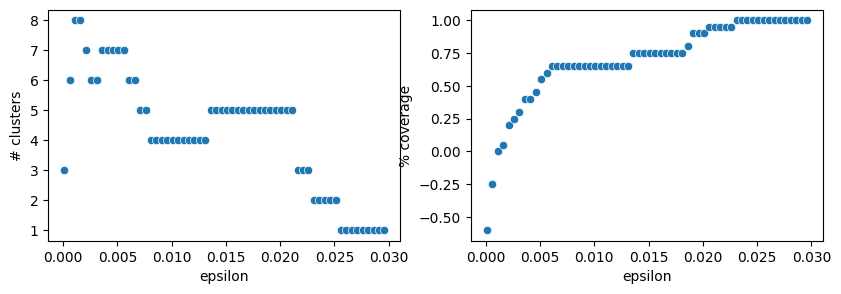

In [271]:
rcParams['figure.figsize'] = [10, 3]
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=grid_search, y=result, ax=ax[0])
sns.scatterplot(x=grid_search, y=cov, ax=ax[1])
ax[0].set_ylabel("# clusters")
ax[1].set_ylabel("% coverage")
ax[0].set_xlabel("epsilon")
ax[1].set_xlabel("epsilon")

In [272]:
clustering = DBSCAN(eps=0.005, min_samples=2, metric="cosine").fit(ssRNAP_pred_embeddings)
ssRNAP_pred["DBSCAN"] = clustering.labels_.tolist()

/tmp/ipykernel_726785/1677945152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssRNAP_pred["DBSCAN"] = clustering.labels_.tolist()


In [273]:
ssRNAP_pred[(ssRNAP_pred.DBSCAN != -1)][["ID", "desc", "DBSCAN"]].sort_values("DBSCAN").to_csv("clusters.csv")

In [277]:
pred_f = ssRNAP_pred[(ssRNAP_pred.DBSCAN >= -1)]
pred_f_emb = pred_f.iloc[:,2:-6].to_numpy()

In [278]:
num_pca_components = 10
pca = PCA(num_pca_components)
ss_pred_pca = pca.fit_transform(pred_f_emb)

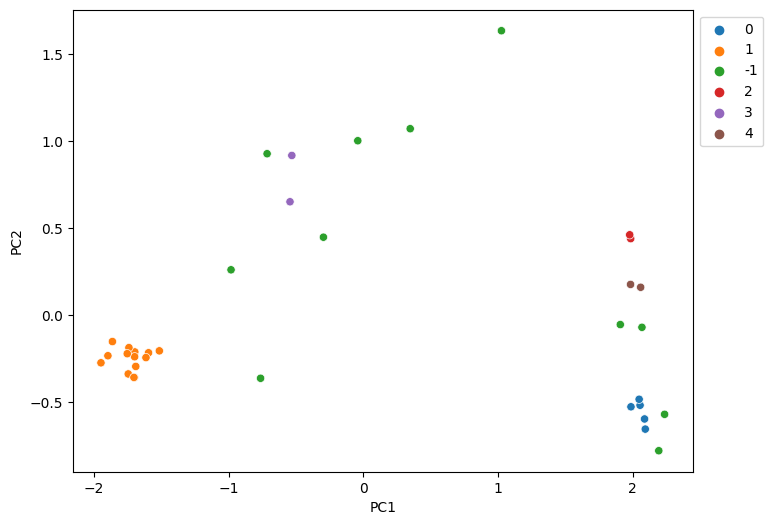

In [279]:
rcParams['figure.figsize'] = [8, 6]
pred_f["DBSCAN"] = pred_f["DBSCAN"].astype(str)

g = sns.scatterplot(x=ss_pred_pca[:,0], y=ss_pred_pca[:,1], hue=list(pred_f["DBSCAN"]))
plt.xlabel("PC1")
plt.ylabel("PC2")
#legend_handles, _ = g.get_legend_handles_labels()
#g.legend(legend_handles, bbox_to_anchor=(1, 1))
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

Orange cluster (1) is a group of DNA dependent RNA polymerases. Purple cluster (3) are exonucleases, and the rest are hypothetical proteins.